使用设备: cuda


100%|██████████| 938/938 [00:05<00:00, 176.43it/s, MSE=0.124] 
499it [00:00, 1618.82it/s]


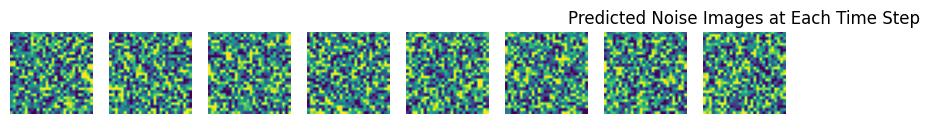

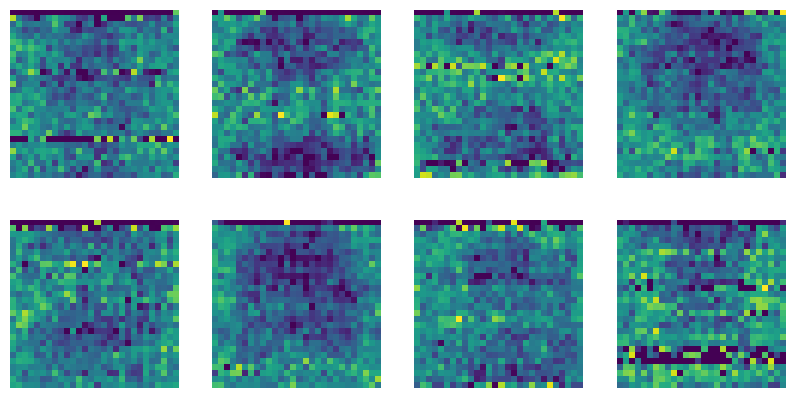

100%|██████████| 938/938 [00:05<00:00, 172.78it/s, MSE=0.0749]
499it [00:00, 1523.28it/s]


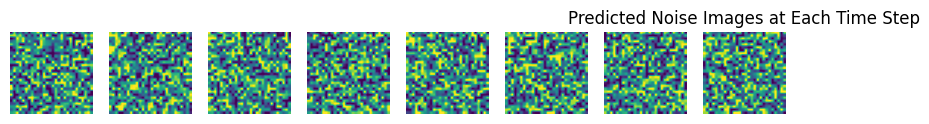

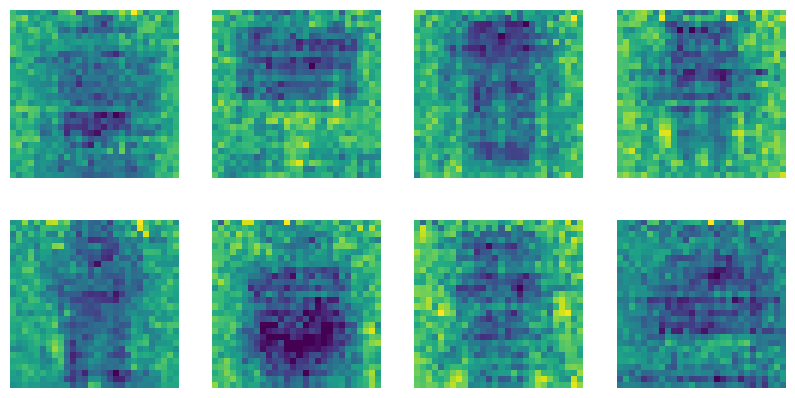

100%|██████████| 938/938 [00:05<00:00, 173.37it/s, MSE=0.105] 
499it [00:00, 1626.51it/s]


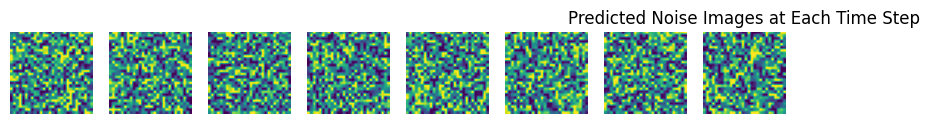

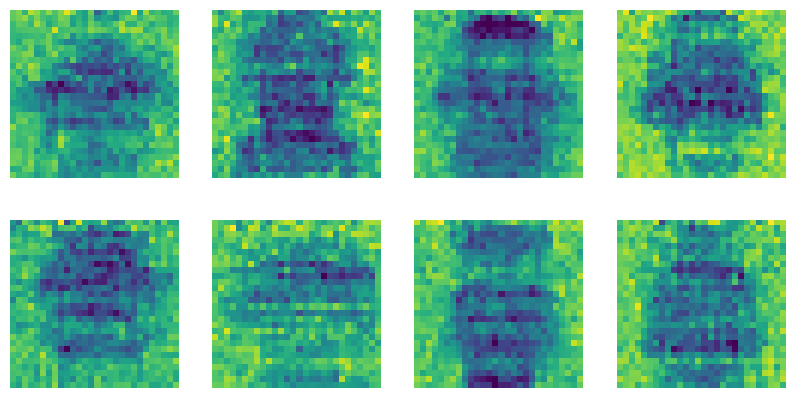

100%|██████████| 938/938 [00:05<00:00, 169.27it/s, MSE=0.0342]
499it [00:00, 1579.79it/s]


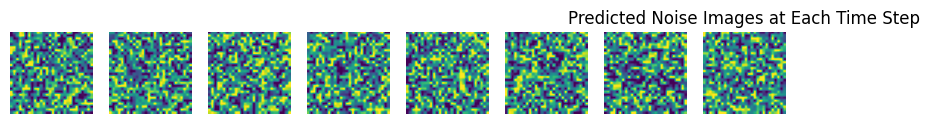

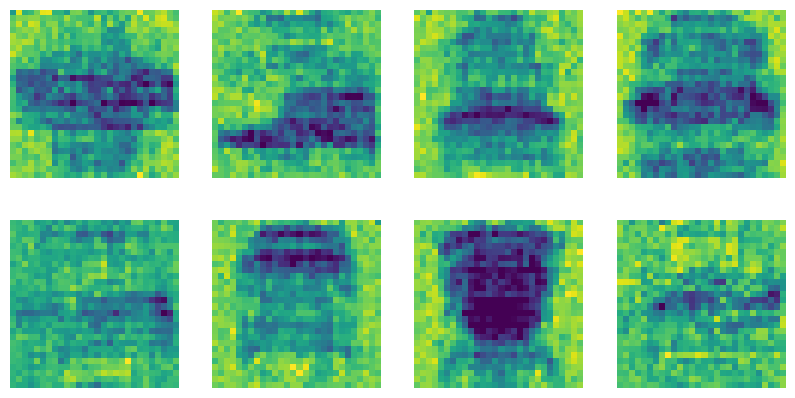

100%|██████████| 938/938 [00:05<00:00, 171.76it/s, MSE=0.044] 
499it [00:00, 1529.72it/s]


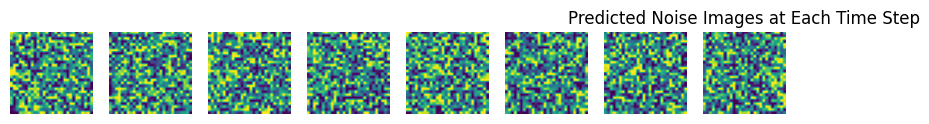

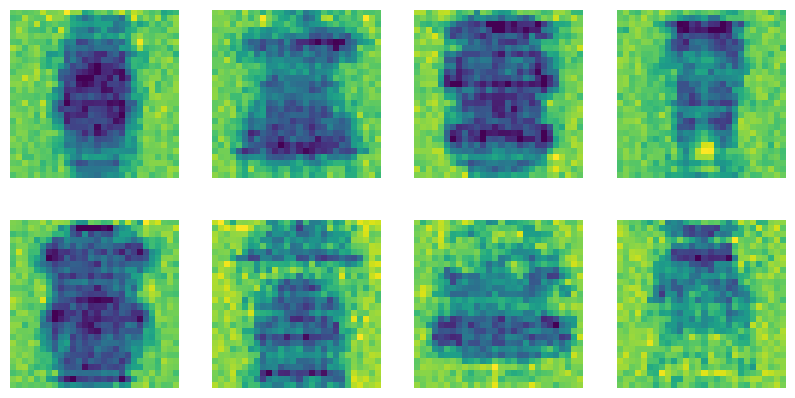

100%|██████████| 938/938 [00:05<00:00, 166.19it/s, MSE=0.091] 
499it [00:00, 1610.15it/s]


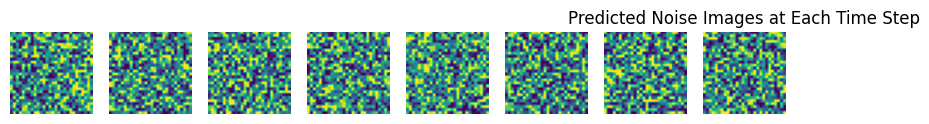

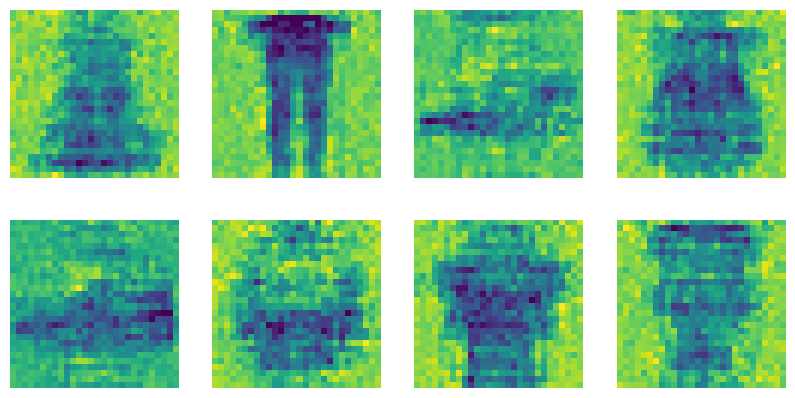

100%|██████████| 938/938 [00:05<00:00, 171.27it/s, MSE=0.0727]
499it [00:00, 1483.95it/s]


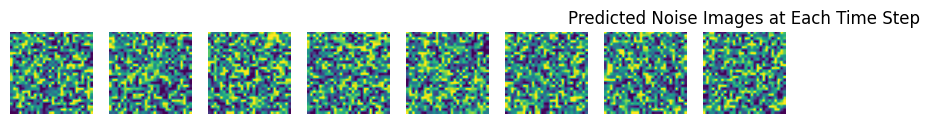

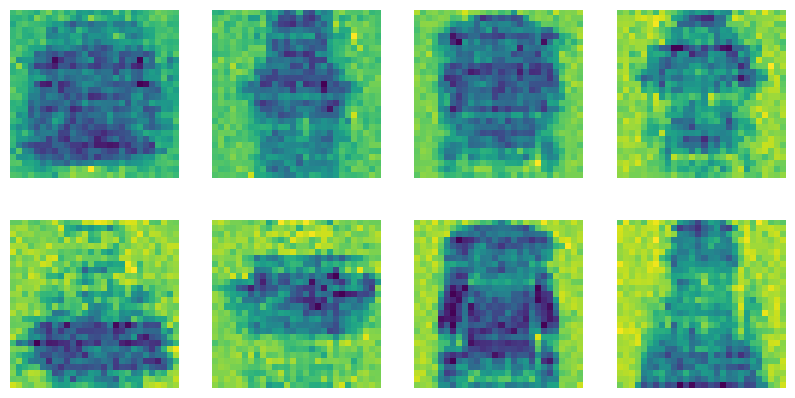

100%|██████████| 938/938 [00:05<00:00, 170.21it/s, MSE=0.037] 
499it [00:00, 1613.08it/s]


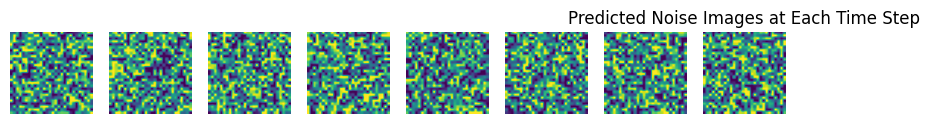

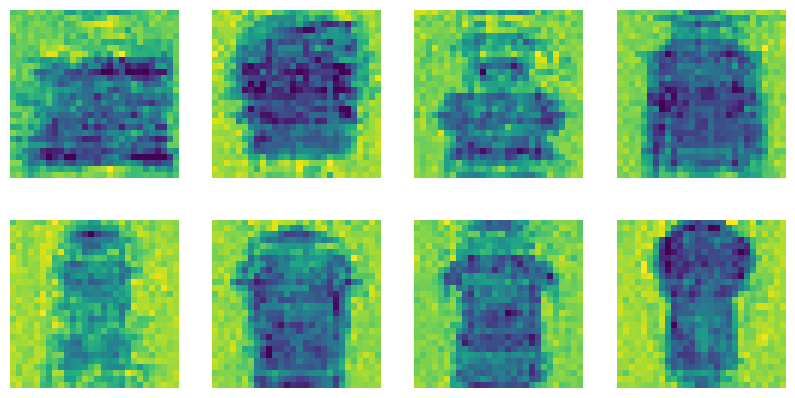

100%|██████████| 938/938 [00:05<00:00, 174.73it/s, MSE=0.0716]
499it [00:00, 1525.85it/s]


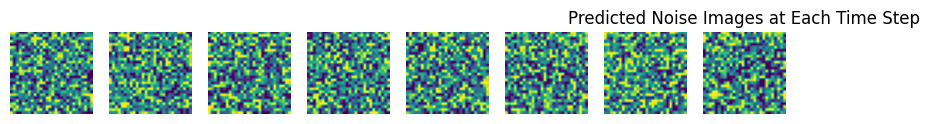

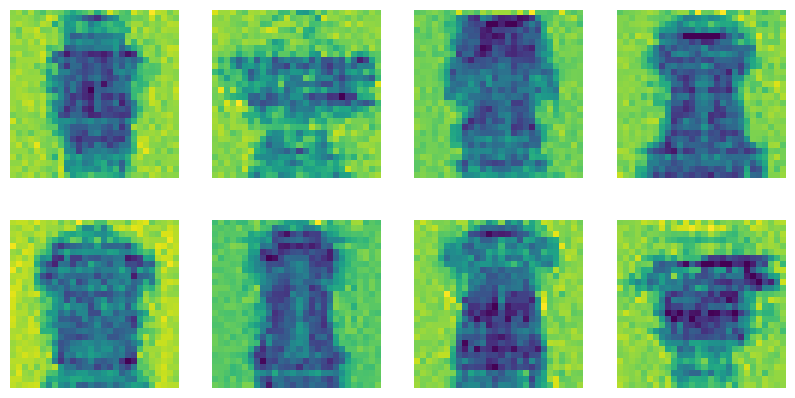

100%|██████████| 938/938 [00:05<00:00, 169.03it/s, MSE=0.0769]
499it [00:00, 1653.40it/s]


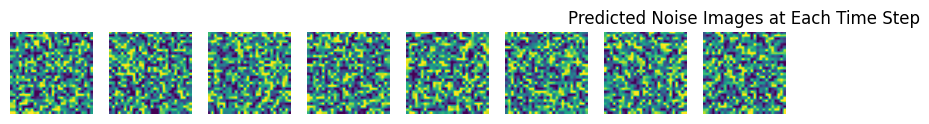

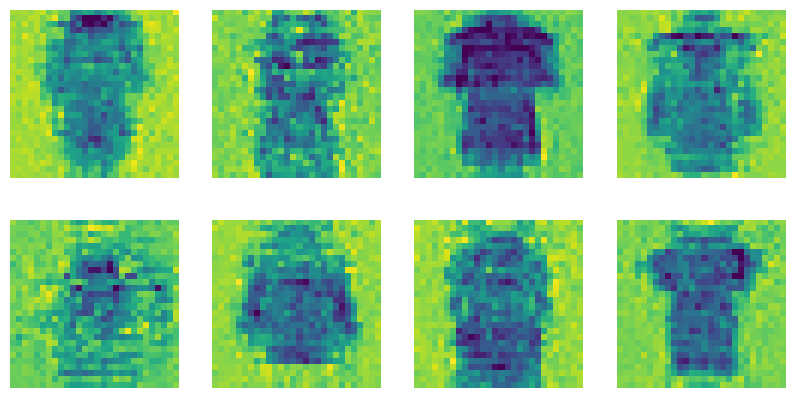

100%|██████████| 938/938 [00:05<00:00, 168.94it/s, MSE=0.0519]
499it [00:00, 1562.34it/s]


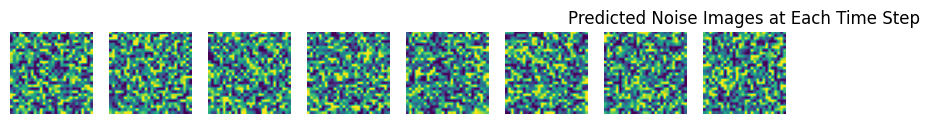

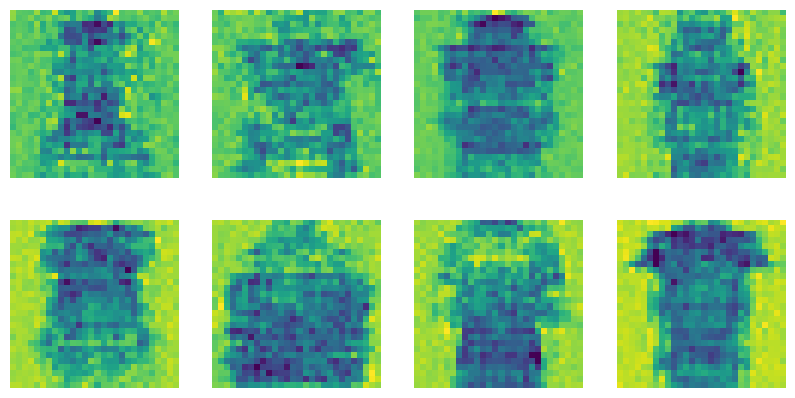

In [3]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
from matplotlib import pyplot as plt
import numpy as np
import logging
from tqdm import tqdm


class EnhancedRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_layers, embedding_size, num_classes):
        super(EnhancedRNN, self).__init__()
        self.hidden_size = hidden_size
        self.num_layers = num_layers

        # 时间步嵌入层
        self.time_embedding_layer = nn.Embedding(num_classes, embedding_size)

        # LSTM 层
        self.lstm = nn.LSTM(input_size + embedding_size, hidden_size, num_layers, batch_first=True)

        # 最终输出层
        self.fc_layer = nn.Linear(hidden_size, input_size)

    def forward(self, input_images, time_indices):
        batch_size, _, height, width = input_images.size()

        # 压缩通道维度，将图像转换为序列 (batch_size, seq_len=28, input_size=28)
        image_seq = input_images.squeeze(1)  # (batch_size, 28, 28)

        # 获取时间嵌入
        time_embedding = self.time_embedding_layer(time_indices)  # (batch_size, embedding_size)
        time_embedding = time_embedding.unsqueeze(1).expand(-1, height, -1)  # (batch_size, 28, embedding_size)

        # 合并图像序列和时间嵌入
        combined_input = torch.cat([image_seq, time_embedding], dim=-1)  # (batch_size, 28, 28 + embedding_size)

        # LSTM 处理
        lstm_output, _ = self.lstm(combined_input)  # (batch_size, 28, hidden_size)

        # 经过全连接层输出
        output = self.fc_layer(lstm_output)  # (batch_size, 28, input_size)

        output = output.unsqueeze(1)  # (batch_size, 1, 28, 28)
        return output



def get_dataloader_workers():
    return 4

def load_data_fashion_mnist(batch_size, resize=None):
    trans = [transforms.ToTensor()]
    if resize:
        trans.insert(0, transforms.Resize(resize))
    trans = transforms.Compose(trans)
    mnist_train = datasets.FashionMNIST(root="./data", train=True, transform=trans, download=True)
    mnist_test = datasets.FashionMNIST(root="./data", train=False, transform=trans, download=True)
    return (DataLoader(mnist_train, batch_size, shuffle=True, num_workers=get_dataloader_workers()),
            DataLoader(mnist_test, batch_size, shuffle=False, num_workers=get_dataloader_workers()))

def get_data(args):
    train_loader, _ = load_data_fashion_mnist(args.batch_size, resize=args.image_size)
    return train_loader

def get_test_data(args):
    _, test_loader = load_data_fashion_mnist(args.batch_size, resize=args.image_size)
    return test_loader

# 扩散模型类
class Diffusion:
    def __init__(self, noise_steps=500, beta_start=1e-4, beta_end=0.02, img_size=28, device="cuda"):
        self.noise_steps = noise_steps  # 将原文中的1000次减为500次
        self.beta_start = beta_start
        self.beta_end = beta_end
        self.img_size = img_size
        self.device = device

        self.beta = self.prepare_noise_schedule().to(device)
        self.alpha = 1. - self.beta
        self.alpha_hat = torch.cumprod(self.alpha, dim=0).to(device)  # 计算alpha的累乘

    def prepare_noise_schedule(self):
        return torch.linspace(self.beta_start, self.beta_end, self.noise_steps)  # 生成beta序列

    def noise_images(self, x, t):
        sqrt_alpha_hat = torch.sqrt(self.alpha_hat[t])[:, None, None, None]  # 计算根号alpha
        sqrt_one_minus_alpha_hat = torch.sqrt(1 - self.alpha_hat[t])[:, None, None, None]  # 根号下1-alpha
        noise = torch.randn_like(x)
        return sqrt_alpha_hat * x + sqrt_one_minus_alpha_hat * noise, noise  # 返回下一个时间步的x_t, 以及生成的随机高斯分布的噪声

    def sample_timesteps(self, n):
        return torch.randint(low=1, high=self.noise_steps, size=(n,), device=self.device)  # 生成时间步数量

    def sample(self, model, n):  # 进行采样，其中model是unet
        logging.info(f"Sampling {n} new images....")
        model.eval()
        with torch.no_grad():
            x = torch.randn((n, 1, self.img_size, self.img_size), device=self.device)
            noise_images = []  # 用于存储每个时间步的噪声图像

            for i in tqdm(reversed(range(1, self.noise_steps)), position=0):
                t = torch.tensor([i] * x.size(0), device=self.device).long()
                predicted_noise = model(x,t)  # 用unet预测噪声

                # 存储当前噪声图像，使用detach()
                noise_images.append(predicted_noise.detach().cpu().numpy())

                alpha = self.alpha[t][:, None, None, None]
                alpha_hat = self.alpha_hat[t][:, None, None, None]
                beta = self.beta[t][:, None, None, None]

                if i > 1:
                    noise = torch.randn_like(x)
                else:
                    noise = torch.zeros_like(x)

                x = 1 / torch.sqrt(alpha) * (x - ((1 - alpha) / (torch.sqrt(1 - alpha_hat))) * predicted_noise) + torch.sqrt(beta) * noise

        model.train()
        x = (x.clamp(-1, 1) + 1) / 2  # 归一化处理
        x = (x * 255).cpu().numpy().astype(np.uint8)  # 转换为图像格式

        # 展示每个时间步的噪声图像
        self.display_noise_images(noise_images[:1])

        return x

    def display_noise_images(self, noise_images):
        """展示噪声图像"""
        plt.figure(figsize=(10, 5))
        n = len(noise_images)  # 时间步数
        for i in range(n):
            img = (noise_images[i].clip(-1, 1) + 1) / 2  # 归一化到 [0, 1]
            img = (img * 255).astype(np.uint8)
            for j in range(img.shape[0]):  # 遍历每个图像
                plt.subplot(n, img.shape[0], i * img.shape[0] + j + 1)
                plt.imshow(img[j, 0])  
                plt.axis('off')
        plt.title("Predicted Noise Images at Each Time Step")
        plt.show()

       


# 训练函数
def train_rnn(args):
    device = torch.device(args.device if torch.cuda.is_available() else "cpu")
    dataloader = get_data(args)
    test_dataloader = get_test_data(args)

    # 初始化模型
    # 4. 实例化RNN去噪网络
    input_dim = 28  # 每行像素数
    hidden_dim = 128
    num_layers = 2
    embed_dim = 32
    num_classes = 500  # 扩散步数

    model = EnhancedRNN(input_dim, hidden_dim, num_layers, embed_dim, num_classes).to(device)
    optimizer = optim.Adam(list(model.parameters()), lr=args.lr)  # 对unet模型的优化器
    mse = nn.MSELoss()  # 这是unet训练的损失函数，均方误差函数
    diffusion = Diffusion(img_size=args.image_size, device=device)

    for epoch in range(args.epochs):
        logging.info(f"Starting epoch {epoch}:")
        pbar = tqdm(dataloader)
        for i, (images, labels) in enumerate(pbar):
            images = images.to(device)
            labels = labels.to(device)

            # 优化模型
            t = diffusion.sample_timesteps(images.size(0)).to(device)
            x_t, noise = diffusion.noise_images(images, t)

            predicted_noise = model(x_t,t)
            loss=mse(noise,predicted_noise)  

            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            pbar.set_postfix(MSE=loss.item())

        if epoch % 4 == 0:  # 进行可视化以及性能评估
            generate_and_display_images(args, model)


# 生成和显示图片
def generate_and_display_images(args, model):
    device = torch.device(args.device if torch.cuda.is_available() else "cpu")
    diffusion = Diffusion(img_size=args.image_size, device=device)

    # 生成图片
    sampled_images = diffusion.sample(model, n=8)

    plt.figure(figsize=(10, 5))
    for i in range(8):
        img = sampled_images[i]
        # 将像素值从范围 [0, 1] 转换为 [0, 255]
        img = (img * 255).astype(np.uint8)
        img = np.transpose(img, (1, 2, 0))
        plt.subplot(2, 4, i + 1)
        plt.imshow(img)
        plt.axis('off')

    plt.show()

    


# 启动函数
def launch():
    import argparse

    # 参数设置
    class ARGS:
        def __init__(self):
            self.run_name = "DDPM_RNN"
            self.epochs = 41
            self.batch_size = 64
            self.image_size = 28
            self.dataset_path = './data'
            self.device = "cuda" if torch.cuda.is_available() else "cpu"
            self.lr = 1.5e-4

    args = ARGS()
    train_rnn(args)


if __name__ == '__main__':
    launch()
